# thal2 1:2 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
                      get_period, bif1d, follow_phase_diffs, phase_lock_r3d,
                      follow_locking_3d)

from lib.rhs import _redu_c,_full
from lib.rhs import _redu_3dc_thal as _redu_3dc

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined,
                           draw_full_solutions)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':3.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-7,'atol':1e-7}

In [6]:
etup12 = (.001,.1,100)
eps_list12r = np.linspace(*etup12)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(idx=0,model_name='thal0_35',**kws1)
system2 = rsp(idx=1,model_name='thal1_35',**kws1)

mkdir ./data/thal0_35/
* Loading LC data...
self.T 6.283185307179586 omfix 1.6947246128737048
* Loading monodromy...
* Floquet Exponent kappa =-0.03594482780785962
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_35/
* Loading LC data...
self.T 6.283185307179586 omfix 1.6947246128737048
* Loading monodromy...
* Floquet Exponent kappa =-0.03594482780785962
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [9]:
recompute_list = ['h_data_thal0_35','h_data_thal1_35','p_data_thal0_35','p_data_thal1_35']
# recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
        'NH':2048,'save_fig':False,'recompute_list':recompute_list}

# del=0.0

In [10]:
del12_p0 = 0
a12_p0 = nm.nmCoupling(**kw_nm, del1=del12_p0)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## H functions

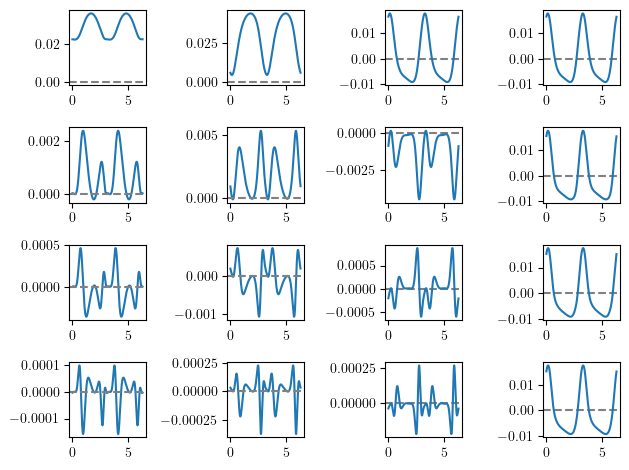

In [11]:
aa = a12_p0
fig,axs = plt.subplots(aa.system1.miter,4)
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k,0].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    axs[k,1].plot(aa.x,etemp**(k+1)*aa.system2.h['lam'][k](aa.x))
    
    axs[k,0].axhline(0,color='gray',ls='--')
    axs[k,1].axhline(0,color='gray',ls='--')
    axs[k,2].axhline(0,color='gray',ls='--')
    axs[k,3].axhline(0,color='gray',ls='--')

    d = aa.system1.h['lam'][k](aa.x)-aa.system2.h['lam'][k](aa.x)
    axs[k,2].plot(aa.x,etemp**(k+1)*d)
    h += etemp**(k+1)*d
    axs[k,3].plot(aa.x,h)

plt.tight_layout()

In [12]:
print(a12_p0.system1.dtlc-a12_p0.system1.dtlc_endpt)

0.0


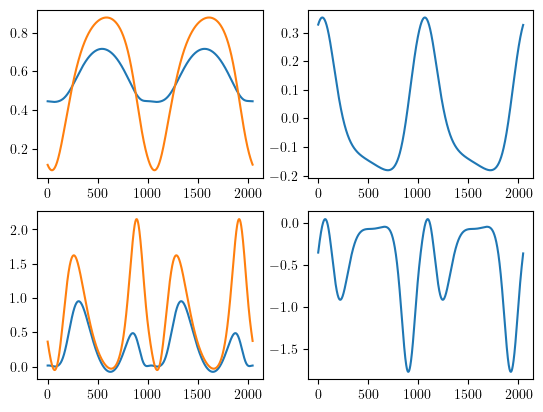

In [13]:
fig,axs = plt.subplots(2,2)
axs[0,0].plot(a12_p0.system1.h['dat'][0])
axs[0,0].plot(a12_p0.system2.h['dat'][0])

axs[0,1].plot(a12_p0.system1.h['dat'][0]-a12_p0.system2.h['dat'][0])

axs[1,0].plot(a12_p0.system1.h['dat'][1])
axs[1,0].plot(a12_p0.system2.h['dat'][1])

axs[1,1].plot(a12_p0.system1.h['dat'][1]-a12_p0.system2.h['dat'][1])

## Get Branches Full

In [14]:
kw_p0 = {'a':a12_p0,'del1':del12_p0,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [15]:
data_p0_list = []

In [16]:
in_dicts = [dict(init=1,eps_init=0.1,eps_final=0.009,deps=-.01),
           dict(init=1,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [17]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)
fname = kw_p0['bifdir']+'hyper_thal2_12_p0.txt'

fname1 td_branch_init=1_nm=12_del=0_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=1_nm=12_del=0_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=1_nm=12_del=0_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=1_nm=12_del=0_ei=0.01_ef=0.0005_de=-0.001.txt


In [18]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [19]:
data_list_r3d = []

In [20]:
kw_follow_r3d = {'a':a12_p0,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [21]:
in_dicts_r3d = [dict(init=1,eps_tup=(.02,.11,.01)),
                dict(init=1,eps_tup=(.02,.001,-.001)),
                dict(init=4,eps_tup=(.02,.11,.01)),
                dict(init=4,eps_tup=(.02,.001,-.001))]

In [22]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p0.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [23]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.007000000000000003


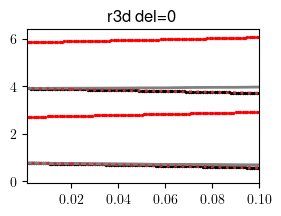

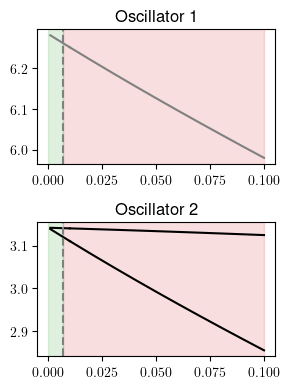

In [24]:
quick_plot_combined(a12_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [25]:
eps12_p0 = 0.15
th_init12_p0 = 0

In [26]:
dt = .01;T_p0=500
t12_p0 = np.arange(0,T_p0,dt)
args12_p0 = {'args':(a12_p0,eps12_p0,del12_p0),
               't_eval':t12_p0,**kw_sim}

In [27]:
y0a = a12_p0.system1.lc['dat'][int((th_init12_p0/(2*np.pi)) * a12_p0.system1.TN),:]
y0b = a12_p0.system2.lc['dat'][int((0/(2*np.pi)) * a12_p0.system2.TN),:]

y0_p0 = np.array([y0a,y0b]).flatten()

solf12_p0 = solve_ivp(_full,[0,t12_p0[-1]],
                        y0_p0, **args12_p0)

In [28]:
solr12_p0 = solve_ivp(_redu_c,[0,t12_p0[-1]],
                        [th_init12_p0],**args12_p0)

In [29]:
# solr12b_p0 = solve_ivp(_redu_3dc,[0,t12_p0[-1]],
#                     [th_init12_p0,0,0],**args12_p0)

In [30]:
tp12a_p0, phase12a_p0 = get_phase(t12_p0,solf12_p0.y.T[:,:4],
                            skipn=50,system1=a12_p0.system1)
tp12b_p0, phase12b_p0 = get_phase(t12_p0,solf12_p0.y.T[:,4:],
                            skipn=50,system1=a12_p0.system2)

(-0.5, 6.783185307179586)

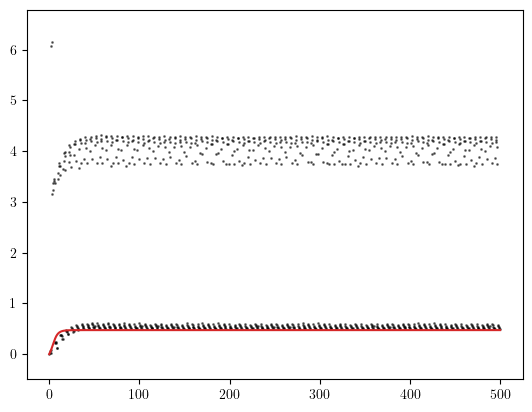

In [31]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p0 - a12_p0.om*phase12b_p0,2*np.pi)
axs.scatter(tp12a_p0,y,s=1,alpha=.5,color='black')

axs.plot(t12_p0,np.mod(solr12_p0.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p0*a12_p0.om,np.mod(solr12b_p0.y[0]-a12_p0.om*solr12b_p0.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

(250.0, 350.0)

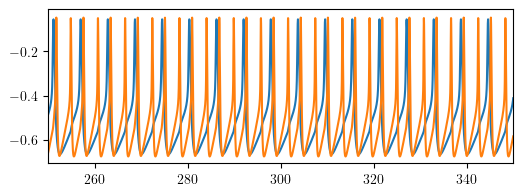

In [32]:
fig,axs = plt.subplots(figsize=(6,2))
axs.plot(solf12_p0.t,solf12_p0.y.T[:,0])
axs.plot(solf12_p0.t,solf12_p0.y.T[:,4])
axs.set_xlim(250,350)

# del=0.01

In [33]:
del12_p01 = .01
a12_p01 = nm.nmCoupling(**kw_nm, del1=1*del12_p01)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


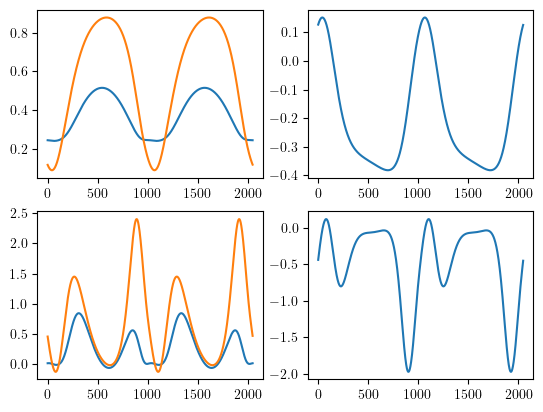

In [34]:
fig,axs = plt.subplots(2,2)
axs[0,0].plot(a12_p01.system1.h['dat'][0])
axs[0,0].plot(a12_p01.system2.h['dat'][0])

axs[0,1].plot(a12_p01.system1.h['dat'][0]-a12_p01.system2.h['dat'][0])

axs[1,0].plot(a12_p01.system1.h['dat'][1])
axs[1,0].plot(a12_p01.system2.h['dat'][1])

axs[1,1].plot(a12_p01.system1.h['dat'][1]-a12_p01.system2.h['dat'][1])

## Get Branches Full

In [35]:
kw_p01 = {'a':a12_p01,'del1':del12_p01,'bifdir':'bif1d_thal2/',
            '_full_rhs':_full,'recompute':False}

In [36]:
data_p01_list = []

In [37]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.002),
           dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
           dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
           dict(init=0,eps_init=0.02,eps_final=0.11,deps=.01)]

In [38]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p01)
    data_p01_list.append(dat)
fname = kw_p01['bifdir']+'hyper_thal2_12_p01.txt'

fname1 td_branch_init=2_nm=12_del=0.01_ei=0.02_ef=0.0005_de=-0.002.txt
fname2 ts_branch_init=2_nm=12_del=0.01_ei=0.02_ef=0.0005_de=-0.002.txt
fname1 td_branch_init=2_nm=12_del=0.01_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=2_nm=12_del=0.01_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.01_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.01_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0.01_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.01_ei=0.02_ef=0.11_de=0.01.txt


In [39]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [215]:
data_list_r3d = []

In [216]:
kw_follow_r3d = {'a':a12_p01,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [217]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.11,.01)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [218]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p01.txt'

eps_tup (0.02, 0.11, 0.01)
0.5 <nmCoupling.nmCoupling object at 0x0000016100990130> (0.02, 0.11, 0.01) <function _redu_3dc_thal at 0x00000161650E7010>
t_diff 0.44725374207791313, Y=[ 0.44725374 -0.0203267   0.00332763]                                              
eps iter 0 0.02                
t_diff 0.44725374207791350, Y=[ 0.44725374 -0.0203267   0.00332763]                                              
eps iter 1 0.03                
t_diff 0.44232629415338664, Y=[ 0.44232629 -0.03052468  0.00502628]                                              
eps iter 2 0.039999999999999994                
t_diff 0.43738310118977514, Y=[ 0.4373831  -0.04074629  0.00674841]                                              
eps iter 3 0.049999999999999996                
t_diff 0.43242395200418833, Y=[ 0.43242395 -0.05099218  0.00849425]                                              
eps iter 4 0.06                
t_diff 0.42744852444222343, Y=[ 0.42744852 -0.06126322  0.01026404]                    

In [219]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.016999999999999998


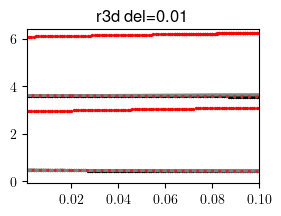

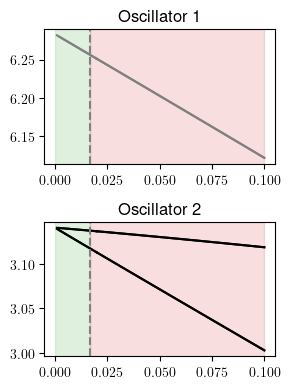

In [220]:
quick_plot_combined(a12_p01,
                    kw_f={'data_list':data_p01_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [46]:
eps12_p01 = 0.15
th_init12_p01 = 3

In [47]:
dt = .01;T_p01=500
t12_p01 = np.arange(0,T_p01,dt)
args12_p01 = {'args':(a12_p01,eps12_p01,del12_p01),
               't_eval':t12_p01,**kw_sim}

In [48]:
y0a = a12_p01.system1.lc['dat'][int((th_init12_p01/(2*np.pi)) * a12_p01.system1.TN),:]
y0b = a12_p01.system2.lc['dat'][int((0/(2*np.pi)) * a12_p01.system2.TN),:]

y0_p01 = np.array([y0a,y0b]).flatten()

solf12_p01 = solve_ivp(_full,[0,t12_p01[-1]],
                        y0_p01, **args12_p01)

In [49]:
solr12_p01 = solve_ivp(_redu_c,[0,t12_p01[-1]],[th_init12_p01],**args12_p01)

In [50]:
# solr12b_p01 = solve_ivp(_redu_3dc,[0,t12_p01[-1]],
#                     [th_init12_p01,0,0],**args12_p01)

In [51]:
tp12a_p01, phase12a_p01 = get_phase(t12_p01,solf12_p01.y.T[:,:4],
                            skipn=50,system1=a12_p01.system1)
tp12b_p01, phase12b_p01 = get_phase(t12_p01,solf12_p01.y.T[:,4:],
                            skipn=50,system1=a12_p01.system2)

(-0.5, 6.783185307179586)

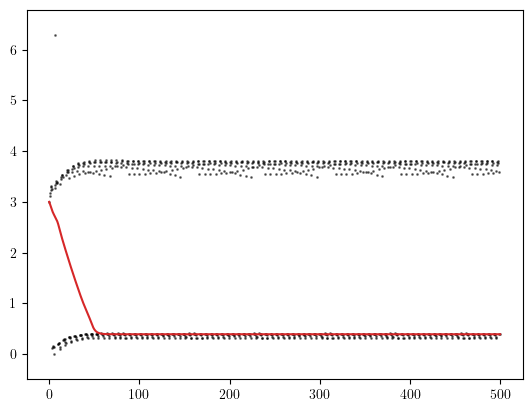

In [52]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p01 - a12_p01.om*phase12b_p01,2*np.pi)
axs.scatter(tp12a_p01,y,s=1,alpha=.5,color='black')

axs.plot(t12_p01,np.mod(solr12_p01.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p01*a12_p01.om,np.mod(solr12b_p01.y[0]-a12_p01.om*solr12b_p01.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

(250.0, 350.0)

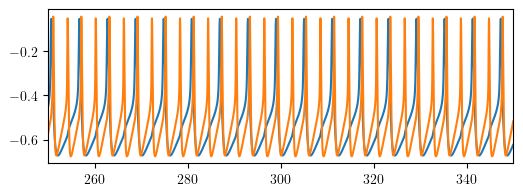

In [53]:
fig,axs = plt.subplots(figsize=(6,2))
axs.plot(solf12_p01.t,solf12_p01.y.T[:,0])
axs.plot(solf12_p01.t,solf12_p01.y.T[:,4])
axs.set_xlim(250,350)

# del=0.012

In [54]:
del12_p012 = .012
a12_p012 = nm.nmCoupling(**kw_nm, del1=1*del12_p012)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [55]:
kw_p012 = {'a':a12_p012,'del1':del12_p012,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [56]:
data_p012_list = []

In [57]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.001),
           dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01)]

In [58]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p012)
    data_p012_list.append(dat)
fname = kw_p012['bifdir']+'hyper_thal2_12_p012.txt'

fname1 td_branch_init=2_nm=12_del=0.012_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.012_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=2_nm=12_del=0.012_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=2_nm=12_del=0.012_ei=0.02_ef=0.11_de=0.01.txt


In [59]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [60]:
data_list_r3d = []

In [61]:
kw_follow_r3d = {'a':a12_p012,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [62]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.11,.01)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [63]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p012.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [64]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

In [65]:
data_r3d_p012_list = []

## Plot

eps_min 0.03


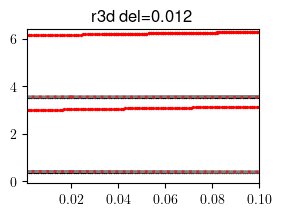

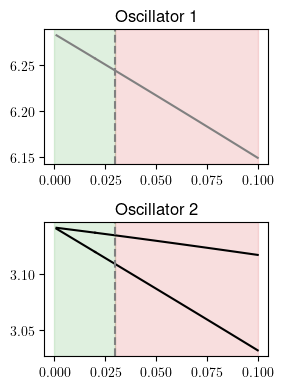

In [66]:
quick_plot_combined(a12_p012,
                    kw_f={'data_list':data_p012_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

# del=0.013

In [67]:
del12_p013 = .013
a12_p013 = nm.nmCoupling(**kw_nm, del1=1*del12_p013)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [68]:
kw_p013 = {'a':a12_p013,'del1':del12_p013,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [69]:
data_p013_list = []

In [70]:
in_dicts = [dict(init=0,eps_init=0.02,eps_final=0.11,deps=.01),
           dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001)]

In [71]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p013)
    data_p013_list.append(dat)
fname = kw_p013['bifdir']+'hyper_thal2_12_p013.txt'

fname1 td_branch_init=0_nm=12_del=0.013_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.013_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.013_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.013_ei=0.02_ef=0.0005_de=-0.001.txt


In [72]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [73]:
data_list_r3d = []

In [74]:
kw_follow_r3d = {'a':a12_p013,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [75]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.11,.01)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [76]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p013.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [77]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.03


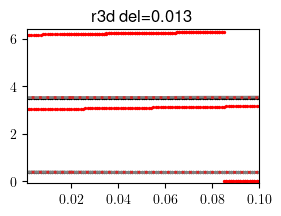

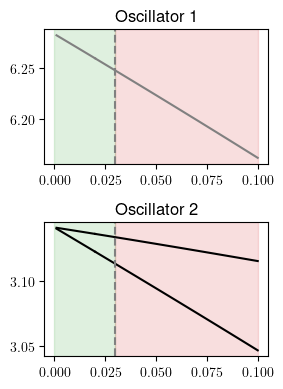

In [78]:
quick_plot_combined(a12_p013,
                    kw_f={'data_list':data_p013_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

# del=0.014

In [79]:
del12_p014 = .014
a12_p014 = nm.nmCoupling(**kw_nm, del1=1*del12_p014)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [80]:
kw_p014 = {'a':a12_p014,'del1':del12_p014,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [81]:
data_p014_list = []

In [82]:
in_dicts = [dict(init=2,eps_init=0.1,eps_final=0.009,deps=-.01),
            dict(init=2,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [83]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p014)
    data_p014_list.append(dat)
fname = kw_p014['bifdir']+'hyper_thal2_12_p014.txt'

fname1 td_branch_init=2_nm=12_del=0.014_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=2_nm=12_del=0.014_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=2_nm=12_del=0.014_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.014_ei=0.01_ef=0.0005_de=-0.001.txt


In [84]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [85]:
data_list_r3d = []

In [86]:
kw_follow_r3d = {'a':a12_p014,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [87]:
in_dicts_r3d = [dict(init=1,eps_tup=(.02,.11,.01)),
                dict(init=1,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [88]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p014.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [89]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.040000000000000036


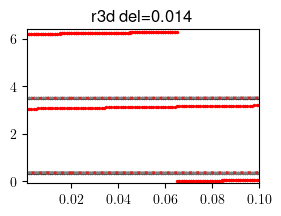

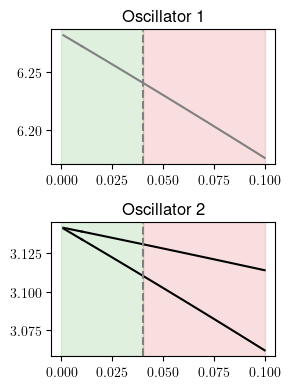

In [90]:
quick_plot_combined(a12_p014,
                    kw_f={'data_list':data_p014_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

# del=0.015

In [91]:
del12_p015 = .015
a12_p015 = nm.nmCoupling(**kw_nm, del1=1*del12_p015)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [92]:
kw_p015 = {'a':a12_p015,'del1':del12_p015,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [93]:
data_p015_list = []

In [94]:
in_dicts = [dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
            dict(init=0,eps_init=0.02,eps_final=0.11,deps=.01)]

In [95]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p015)
    data_p015_list.append(dat)
fname = kw_p015['bifdir']+'hyper_thal2_12_p015.txt'

fname1 td_branch_init=0_nm=12_del=0.015_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.015_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0.015_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.015_ei=0.02_ef=0.11_de=0.01.txt


In [96]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [97]:
data_list_r3d = []

In [98]:
kw_follow_r3d = {'a':a12_p015,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [99]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.11,.01)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [100]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p015.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [101]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.06999999999999999


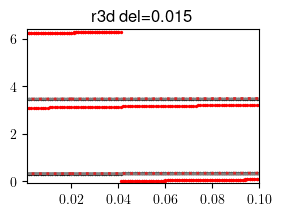

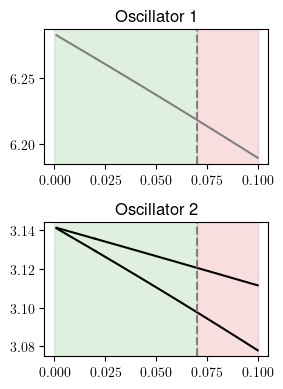

In [102]:
quick_plot_combined(a12_p015,
                    kw_f={'data_list':data_p015_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

# del=0.016

In [103]:
del12_p016 = .016
a12_p016 = nm.nmCoupling(**kw_nm, del1=1*del12_p016)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [104]:
kw_p016 = {'a':a12_p016,'del1':del12_p016,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [105]:
data_p016_list = []

In [106]:
in_dicts = [dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
            dict(init=0,eps_init=0.02,eps_final=0.11,deps=.01)]

In [107]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p016)
    data_p016_list.append(dat)
fname = kw_p016['bifdir']+'hyper_thal2_12_p016.txt'

fname1 td_branch_init=0_nm=12_del=0.016_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.016_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0.016_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.016_ei=0.02_ef=0.11_de=0.01.txt


In [108]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [109]:
data_list_r3d = []

In [110]:
kw_follow_r3d = {'a':a12_p016,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [111]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.11,.01)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [112]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p016.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [113]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

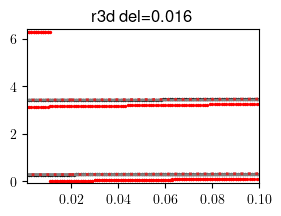

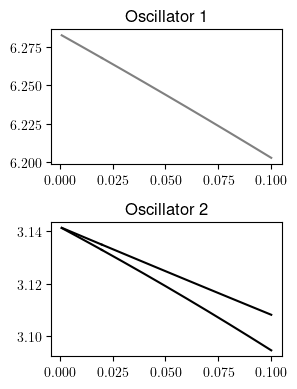

In [114]:
quick_plot_combined(a12_p016,
                    kw_f={'data_list':data_p016_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [115]:
eps12_p016 = 0.25
th_init12_p016 = 2.8

In [116]:
dt = .01;T_p016=500
t12_p016 = np.arange(0,T_p016,dt)
args12_p016 = {'args':(a12_p016,eps12_p016,del12_p016),
               't_eval':t12_p016,**kw_sim}

In [117]:
y0a = a12_p016.system1.lc['dat'][int((th_init12_p016/(2*np.pi)) * a12_p016.system1.TN),:]
y0b = a12_p016.system2.lc['dat'][int((0/(2*np.pi)) * a12_p016.system2.TN),:]

y0_p016 = np.array([y0a,y0b]).flatten()

solf12_p016 = solve_ivp(_full,[0,t12_p016[-1]],
                        y0_p016, **args12_p016)

In [118]:
solr12_p016 = solve_ivp(_redu_c,[0,t12_p016[-1]],
                        [th_init12_p016],**args12_p016)

In [119]:
# solr12b_p016 = solve_ivp(_redu_3dc,[0,t12_p016[-1]],
                    # [th_init12_p016,0,0],**args12_p016)

In [120]:
tp12a_p016, phase12a_p016 = get_phase(t12_p016,solf12_p016.y.T[:,:4],
                            skipn=50,system1=a12_p016.system1)
tp12b_p016, phase12b_p016 = get_phase(t12_p016,solf12_p016.y.T[:,4:],
                            skipn=50,system1=a12_p016.system2)

(-0.5, 6.783185307179586)

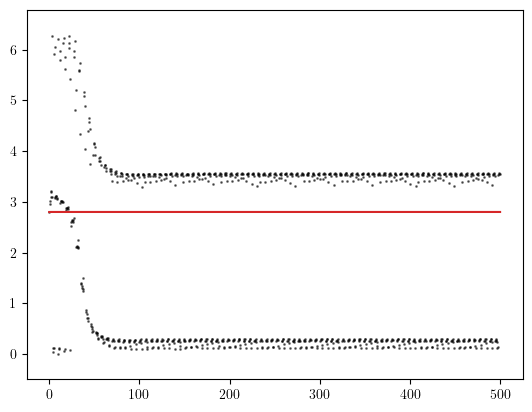

In [121]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p016 - a12_p016.om*phase12b_p016,2*np.pi)
axs.scatter(tp12a_p016,y,s=1,alpha=.5,color='black')

axs.plot(t12_p016,np.mod(solr12_p016.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p016*a12_p016.om,np.mod(solr12b_p016.y[0]-a12_p016.om*solr12b_p016.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.017

In [122]:
del12_p017 = .017
a12_p017 = nm.nmCoupling(**kw_nm, del1=1*del12_p017)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [123]:
kw_p017 = {'a':a12_p017,'del1':del12_p017,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [124]:
data_p017_list = []

In [125]:
in_dicts = [dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
            dict(init=0,eps_init=0.02,eps_final=0.11,deps=.01)]

In [126]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p017)
    data_p017_list.append(dat)
fname = kw_p017['bifdir']+'hyper_thal2_12_p017.txt'

fname1 td_branch_init=0_nm=12_del=0.017_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.017_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0.017_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.017_ei=0.02_ef=0.11_de=0.01.txt


In [127]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [128]:
data_list_r3d = []

In [129]:
kw_follow_r3d = {'a':a12_p017,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [130]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.11,.01)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.11,.01)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [131]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p017.txt'

eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.11, 0.01)
eps_tup (0.02, 0.001, -0.001)


In [132]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

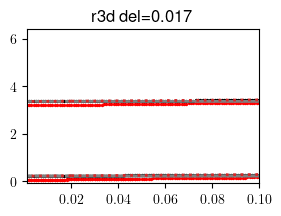

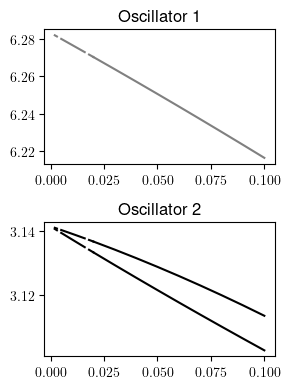

In [133]:
quick_plot_combined(a12_p017,
                    kw_f={'data_list':data_p017_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [134]:
eps12_p017 = 0.25
th_init12_p017 = 2.8

In [135]:
dt = .01;T_p017=500
t12_p017 = np.arange(0,T_p017,dt)
args12_p017 = {'args':(a12_p017,eps12_p017,del12_p017),
               't_eval':t12_p017,**kw_sim}

In [136]:
y0a = a12_p017.system1.lc['dat'][int((th_init12_p017/(2*np.pi)) * a12_p017.system1.TN),:]
y0b = a12_p017.system2.lc['dat'][int((0/(2*np.pi)) * a12_p017.system2.TN),:]

y0_p017 = np.array([y0a,y0b]).flatten()

solf12_p017 = solve_ivp(_full,[0,t12_p017[-1]],
                        y0_p017, **args12_p017)

In [137]:
solr12_p017 = solve_ivp(_redu_c,[0,t12_p017[-1]],
                        [th_init12_p017],**args12_p017)

In [138]:
# solr12b_p017 = solve_ivp(_redu_3dc,[0,t12_p017[-1]],
                    # [th_init12_p017,0,0],**args12_p017)

In [139]:
tp12a_p017, phase12a_p017 = get_phase(t12_p017,solf12_p017.y.T[:,:4],
                            skipn=50,system1=a12_p017.system1)
tp12b_p017, phase12b_p017 = get_phase(t12_p017,solf12_p017.y.T[:,4:],
                            skipn=50,system1=a12_p017.system2)

(-0.5, 6.783185307179586)

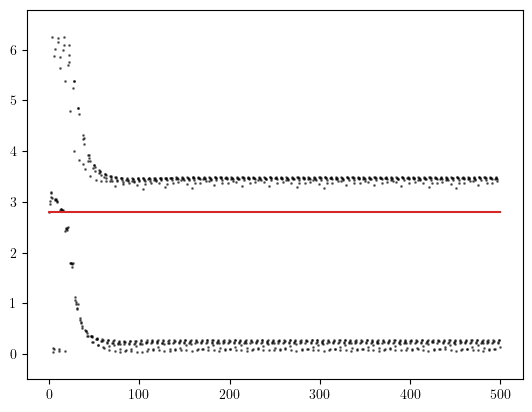

In [140]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p017 - a12_p017.om*phase12b_p017,2*np.pi)
axs.scatter(tp12a_p017,y,s=1,alpha=.5,color='black')

axs.plot(t12_p017,np.mod(solr12_p017.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p017*a12_p017.om,np.mod(solr12b_p017.y[0]-a12_p017.om*solr12b_p017.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.0175

In [141]:
del12_p0175 = .0175
a12_p0175 = nm.nmCoupling(**kw_nm, del1=1*del12_p0175)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [142]:
kw_p0175 = {'a':a12_p0175,'del1':del12_p0175,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [143]:
data_p0175_list = []

In [144]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.009,deps=-.01),
            dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [145]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0175)
    data_p0175_list.append(dat)
fname = kw_p0175['bifdir']+'hyper_thal2_12_p0175.txt'

fname1 td_branch_init=0_nm=12_del=0.0175_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.0175_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=0_nm=12_del=0.0175_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.0175_ei=0.01_ef=0.0005_de=-0.001.txt


In [146]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [147]:
data_list_r3d = []

In [148]:
kw_follow_r3d = {'a':a12_p0175,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/','max_iter':30}

In [149]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.05,.002)),
                dict(init=.5,eps_tup=(.02,.001,-.001)),
                dict(init=3.5,eps_tup=(.02,.05,.002)),
                dict(init=3.5,eps_tup=(.02,.001,-.001))]

In [150]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p0175.txt'

eps_tup (0.02, 0.05, 0.002)
eps_tup (0.02, 0.001, -0.001)
eps_tup (0.02, 0.05, 0.002)
eps_tup (0.02, 0.001, -0.001)


In [151]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.07000000000000002


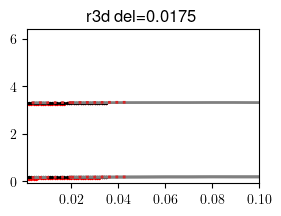

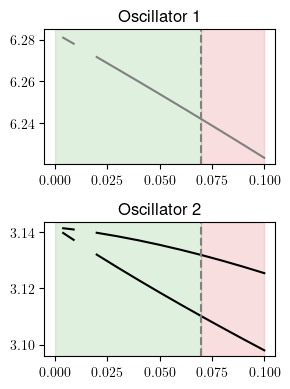

In [152]:
quick_plot_combined(a12_p0175,
                    kw_f={'data_list':data_p0175_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [153]:
eps12_p0175 = 0.06
th_init12_p0175 = 3

In [154]:
dt = .01;T_p0175=1000
t12_p0175 = np.arange(0,T_p0175,dt)
args12_p0175 = {'args':(a12_p0175,eps12_p0175,del12_p0175),
               't_eval':t12_p0175,**kw_sim}

In [155]:
idx1 = int((th_init12_p0175/(2*np.pi)) * a12_p0175.system1.TN)
idx2 = int((0/(2*np.pi)) * a12_p0175.system2.TN)
y0a = a12_p0175.system1.lc['dat'][idx1,:]
y0b = a12_p0175.system2.lc['dat'][idx2,:]

y0_p0175 = np.array([y0a,y0b]).flatten()

solf12_p0175 = solve_ivp(_full,[0,t12_p0175[-1]],y0_p0175, **args12_p0175)

In [156]:
solr12_p0175 = solve_ivp(_redu_c,[0,t12_p0175[-1]],
                        [th_init12_p0175],**args12_p0175)

In [157]:
# solr12b_p0175 = solve_ivp(_redu_3dc,[0,t12_p0175[-1]],
#                     [th_init12_p0175,0,0],**args12_p0175)

In [158]:
tp12a_p0175, phase12a_p0175 = get_phase(t12_p0175,solf12_p0175.y.T[:,:4],
                            skipn=50,system1=a12_p0175.system1)
tp12b_p0175, phase12b_p0175 = get_phase(t12_p0175,solf12_p0175.y.T[:,4:],
                            skipn=50,system1=a12_p0175.system2)

(-0.5, 6.783185307179586)

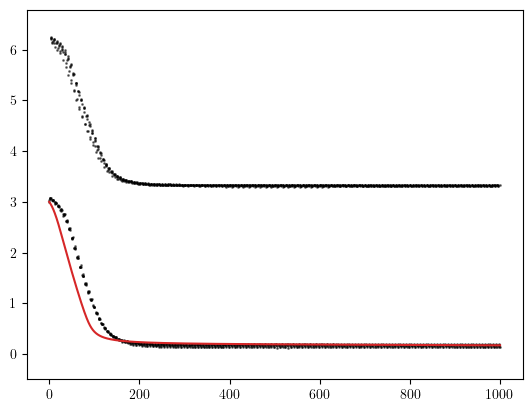

In [159]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p0175 - a12_p0175.om*phase12b_p0175,2*np.pi)
axs.scatter(tp12a_p0175,y,s=1,alpha=.5,color='black')

axs.plot(t12_p0175,np.mod(solr12_p0175.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p0175*a12_p0175.om,np.mod(solr12b_p0175.y[0]-a12_p0175.om*solr12b_p0175.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.01752

In [160]:
del12_p01752 = .01752
a12_p01752 = nm.nmCoupling(**kw_nm, del1=1*del12_p01752)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [161]:
kw_p01752 = {'a':a12_p01752,'del1':del12_p01752,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [162]:
data_p01752_list = []

In [163]:
in_dicts = [dict(init=0,eps_init=0.02,eps_final=0.081,deps=.01),
            dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001)]

In [164]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p01752)
    data_p01752_list.append(dat)
fname = kw_p01752['bifdir']+'hyper_thal2_12_p01752.txt'

fname1 td_branch_init=0_nm=12_del=0.01752_ei=0.02_ef=0.081_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.01752_ei=0.02_ef=0.081_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.01752_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.01752_ei=0.02_ef=0.0005_de=-0.001.txt


In [165]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [166]:
data_list_r3d = []

In [167]:
kw_follow_r3d = {'a':a12_p01752,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/','max_iter':20}

In [168]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.031,.001)),
                dict(init=.5,eps_tup=(.02,.0009,-.001)),
                dict(init=3.5,eps_tup=(.02,.031,.001)),
                dict(init=3.5,eps_tup=(.02,.0009,-.001))]

In [169]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p01752.txt'

eps_tup (0.02, 0.031, 0.001)
eps_tup (0.02, 0.0009, -0.001)
eps_tup (0.02, 0.031, 0.001)
eps_tup (0.02, 0.0009, -0.001)


In [170]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.06


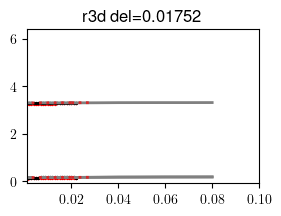

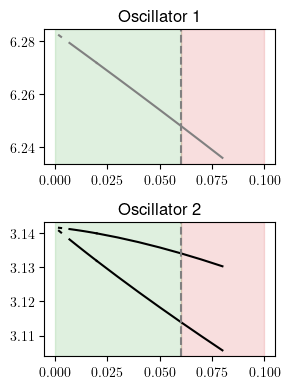

In [171]:
quick_plot_combined(a12_p01752,
                    kw_f={'data_list':data_p01752_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [172]:
eps12_p01752 = 0.2
th_init12_p01752 = 3

In [173]:
dt = .01;T_p01752=1000
t12_p01752 = np.arange(0,T_p01752,dt)
args12_p01752 = {'args':(a12_p01752,eps12_p01752,del12_p01752),
               't_eval':t12_p01752,**kw_sim}

In [174]:
idx1 = int((th_init12_p01752/(2*np.pi)) * a12_p01752.system1.TN)
idx2 = int((0/(2*np.pi)) * a12_p01752.system2.TN)
y0a = a12_p01752.system1.lc['dat'][idx1,:]
y0b = a12_p01752.system2.lc['dat'][idx2,:]

y0_p01752 = np.array([y0a,y0b]).flatten()

solf12_p01752 = solve_ivp(_full,[0,t12_p01752[-1]],y0_p01752, **args12_p01752)

In [175]:
solr12_p01752 = solve_ivp(_redu_c,[0,t12_p01752[-1]],
                        [th_init12_p01752],**args12_p01752)

In [176]:
# solr12b_p01752 = solve_ivp(_redu_3dc,[0,t12_p01752[-1]],
#                     [th_init12_p01752,0,0],**args12_p01752)

In [177]:
tp12a_p01752, phase12a_p01752 = get_phase(t12_p01752,solf12_p01752.y.T[:,:4],
                            skipn=50,system1=a12_p01752.system1)
tp12b_p01752, phase12b_p01752 = get_phase(t12_p01752,solf12_p01752.y.T[:,4:],
                            skipn=50,system1=a12_p01752.system2)

(-0.5, 6.783185307179586)

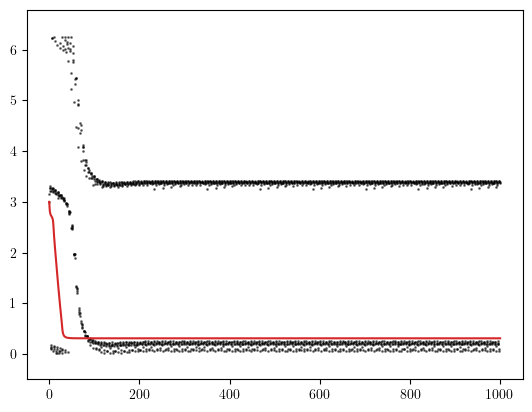

In [178]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p01752 - a12_p01752.om*phase12b_p01752,2*np.pi)
axs.scatter(tp12a_p01752,y,s=1,alpha=.5,color='black')

axs.plot(t12_p01752,np.mod(solr12_p01752.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p01752*a12_p01752.om,np.mod(solr12b_p01752.y[0]-a12_p01752.om*solr12b_p01752.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.01755

In [179]:
del12_p01755 = .01755
a12_p01755 = nm.nmCoupling(**kw_nm, del1=1*del12_p01755)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [180]:
kw_p01755 = {'a':a12_p01755,'del1':del12_p01755,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full,'recompute':False}

In [181]:
data_p01755_list = []

In [182]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.009,deps=-.01),
            dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [183]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p01755)
    data_p01755_list.append(dat)
fname = kw_p01755['bifdir']+'hyper_thal2_12_p01755.txt'

fname1 td_branch_init=0_nm=12_del=0.01755_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=0_nm=12_del=0.01755_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=0_nm=12_del=0.01755_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.01755_ei=0.01_ef=0.0005_de=-0.001.txt


In [184]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [185]:
data_list_r3d = []

In [186]:
kw_follow_r3d = {'a':a12_p01755,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/','max_iter':20}

In [187]:
in_dicts_r3d = [dict(init=.5,eps_tup=(.02,.04,.01)),
                dict(init=.5,eps_tup=(.02,.01,-.005)),
                dict(init=3.5,eps_tup=(.02,.04,.01)),
                dict(init=3.5,eps_tup=(.02,.01,-.005))]

In [188]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_12_p01755.txt'

eps_tup (0.02, 0.04, 0.01)
eps_tup (0.02, 0.01, -0.005)
eps_tup (0.02, 0.04, 0.01)
eps_tup (0.02, 0.01, -0.005)


In [189]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

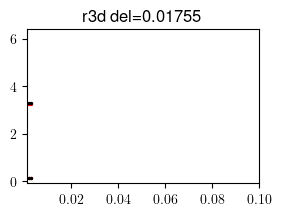

In [190]:
quick_plot_combined(a12_p01755,
                    #kw_f={'data_list':data_p0178_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [191]:
eps12_p01755 = 0.2
th_init12_p01755 = 3

In [192]:
dt = .01;T_p01755=1000
t12_p01755 = np.arange(0,T_p01755,dt)
args12_p01755 = {'args':(a12_p01755,eps12_p01755,del12_p01755),
               't_eval':t12_p01755,**kw_sim}

In [193]:
idx1 = int((th_init12_p01755/(2*np.pi)) * a12_p01755.system1.TN)
idx2 = int((0/(2*np.pi)) * a12_p01755.system2.TN)
y0a = a12_p01755.system1.lc['dat'][idx1,:]
y0b = a12_p01755.system2.lc['dat'][idx2,:]

y0_p01755 = np.array([y0a,y0b]).flatten()

solf12_p01755 = solve_ivp(_full,[0,t12_p01755[-1]],y0_p01755, **args12_p01755)

In [194]:
solr12_p01755 = solve_ivp(_redu_c,[0,t12_p01755[-1]],
                        [th_init12_p01755],**args12_p01755)

In [195]:
# solr12b_p01755 = solve_ivp(_redu_3dc,[0,t12_p01755[-1]],
#                     [th_init12_p01755,0,0],**args12_p01755)

In [196]:
tp12a_p01755, phase12a_p01755 = get_phase(t12_p01755,solf12_p01755.y.T[:,:4],
                            skipn=50,system1=a12_p01755.system1)
tp12b_p01755, phase12b_p01755 = get_phase(t12_p01755,solf12_p01755.y.T[:,4:],
                            skipn=50,system1=a12_p01755.system2)

(-0.5, 6.783185307179586)

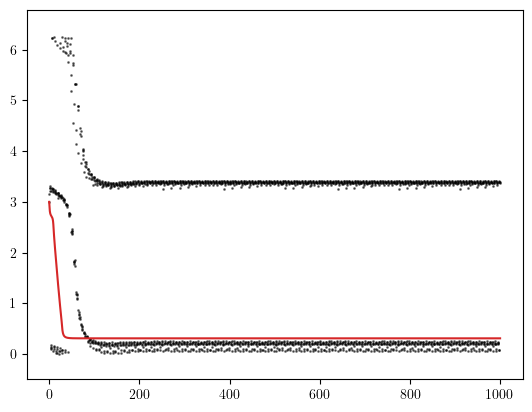

In [197]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p01755 - a12_p01755.om*phase12b_p01755,2*np.pi)
axs.scatter(tp12a_p01755,y,s=1,alpha=.5,color='black')

axs.plot(t12_p01755,np.mod(solr12_p01755.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p01755*a12_p01755.om,np.mod(solr12b_p01755.y[0]-a12_p01755.om*solr12b_p01755.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.0178

In [198]:
del12_p0178 = .0178
a12_p0178 = nm.nmCoupling(**kw_nm, del1=1*del12_p0178)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


## Get Branches Full

In [199]:
kw_p0178 = {'a':a12_p0178,'del1':del12_p0178,'bifdir':'bif1d_thal2/',
          '_full_rhs':_full}

In [200]:
data_p0178_list = []

In [201]:
# # top 1b
# dat = follow_phase_diffs(init=0,eps_init=0.2,eps_final=0.31,
#                          deps=.01,**kw_p0178)
# data_p0178_list.append(dat)

t_diffs [-5.97354096 -5.97354096 -2.92840475] periods [6.14635133 3.04510774 3.10123882]
eps iter 4 0.24000000000000005                


t_diffs [-5.9636723  -5.9636723  -2.92356927] periods [6.13966151 3.04183597 3.09782555]
eps iter 5 0.25000000000000006                


t_diffs [-5.95712382 -5.95712382 -2.91976173] periods [6.13290244 3.03860696 3.0942979 ]
eps iter 6 0.26000000000000006                


t_diffs [-5.94980322 -5.94980322 -2.91477755] periods [6.12607046 3.03540223 3.09066823]
eps iter 7 0.2700000000000001                


t_diffs [-5.94167265 -5.94167265 -2.90967489] periods [6.11916744 3.0322397  3.08692675]
eps iter 8 0.2800000000000001                


t_diffs [-5.92771967 -5.92771967 -2.89957374] periods [6.11218476 3.02910953 3.08307498]
eps iter 9 0.2900000000000001                


t_diffs [-5.91937381 -5.91937381 -2.89383615] periods [6.10513113 3.02601315 3.07911414]
eps iter 10 0.3000000000000001                


t_diffs [-5.91089421 -5.91089421 -2.8891348 ] periods [6.09799564 3.02295101 3.07504467]


In [202]:
# # top 1f
# dat = follow_phase_diffs(init=0,eps_init=0.2,eps_final=0.09,
#                          deps=-.01,**kw_p0178)
# data_p0178_list.append(dat)

t_diffs [-6.0195974 -6.0195974 -2.9556776] periods [6.18503047 3.06553826 3.11949221]
eps iter 4 0.15999999999999998                


t_diffs [-6.02725881 -6.02725881 -2.95821422] periods [6.19124608 3.06908216 3.12216268]
eps iter 5 0.14999999999999997                


t_diffs [-6.03971045 -6.03971045 -2.96924589] periods [6.19739778 3.07266879 3.12472899]
eps iter 6 0.13999999999999996                


t_diffs [-6.04615116 -6.04615116 -2.97020058] periods [6.20348688 3.07628124 3.12720453]
eps iter 7 0.12999999999999995                


t_diffs [-6.05576375 -6.05576375 -2.97655123] periods [6.20951431 3.07992021 3.1295941 ]
eps iter 8 0.11999999999999994                


t_diffs [-6.06686029 -6.06686029 -2.98360287] periods [6.21548058 3.0835673  3.13191607]
eps iter 9 0.10999999999999993                


t_diffs [-6.07611506 -6.07611506 -2.99220183] periods [6.22138772 3.08716432 3.13422327]
eps iter 10 0.09999999999999992                


t_diffs [-6.08953177 -6.08953177 -3.00250558] periods [6.22722499 3.09052947 3.13669047]
eps iter 11 0.08999999999999991                


## Get Branches 3D

In [203]:
data_r3d_p0178_list = []

In [204]:
# # find init for this branch
# _,init = phase_lock_r3d([.5,0,0],a12_p0178,.01,_redu_3dc)
# print(init)

In [205]:
# # top 1f
# dat = follow_locking_3d(init,a12_p0178,(.01,.04,.01),
#                         rhs=_redu_3dc,recompute=False)
# data_r3d_p0178_list.append(dat)

In [206]:
# # top 1b
# dat = follow_locking_3d(init,a12_p0178,(.01,.001,-.001),
#                         rhs=_redu_3dc,recompute=False)
# data_r3d_p0178_list.append(dat)

## Plot

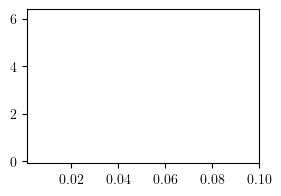

In [207]:
quick_plot_combined(a12_p0178,
                    #kw_f={'data_list':data_p0178_list},
                    #kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup12})

## Sims

In [208]:
eps12_p0178 = 0.05
th_init12_p0178 = 0

In [209]:
dt = .01;T_p0178=1000
t12_p0178 = np.arange(0,T_p0178,dt)
args12_p0178 = {'args':(a12_p0178,eps12_p0178,del12_p0178),
               't_eval':t12_p0178,**kw_sim}

In [210]:
idx1 = int((th_init12_p0178/(2*np.pi)) * a12_p0178.system1.TN)
idx2 = int((0/(2*np.pi)) * a12_p0178.system2.TN)
y0a = a12_p0178.system1.lc['dat'][idx1,:]
y0b = a12_p0178.system2.lc['dat'][idx2,:]

y0_p0178 = np.array([y0a,y0b]).flatten()

solf12_p0178 = solve_ivp(_full,[0,t12_p0178[-1]],y0_p0178, **args12_p0178)

In [211]:
solr12_p0178 = solve_ivp(_redu_c,[0,t12_p0178[-1]],
                        [th_init12_p0178],**args12_p0178)

In [212]:
# solr12b_p0178 = solve_ivp(_redu_3dc,[0,t12_p0178[-1]],
#                     [th_init12_p0178,0,0],**args12_p0178)

In [213]:
tp12a_p0178, phase12a_p0178 = get_phase(t12_p0178,solf12_p0178.y.T[:,:4],
                            skipn=50,system1=a12_p0178.system1)
tp12b_p0178, phase12b_p0178 = get_phase(t12_p0178,solf12_p0178.y.T[:,4:],
                            skipn=50,system1=a12_p0178.system2)

(-0.5, 6.783185307179586)

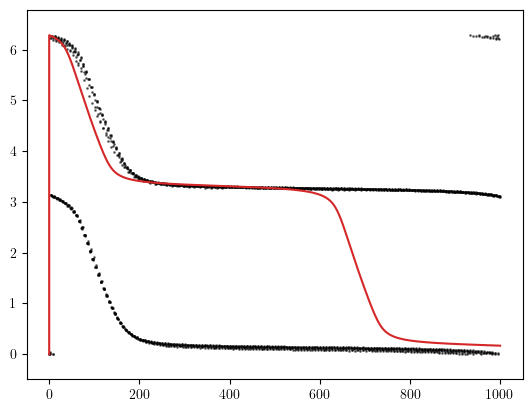

In [214]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p0178 - a12_p0178.om*phase12b_p0178,2*np.pi)
axs.scatter(tp12a_p0178,y,s=1,alpha=.5,color='black')

axs.plot(t12_p0178,np.mod(solr12_p0178.y.T,2*np.pi),color='tab:red')

# axs.plot(t12_p0178*a12_p0178.om,np.mod(solr12b_p0178.y[0]-a12_p0178.om*solr12b_p0178.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)